# Bechmark: Vern9 vs IRKGL16 (Float64) 

<ul id="top">
    <li><a href="#Loading-packages"> 
             Loading Packages</a></li>

<li><a href="#Initial-value-problem:-Burrau-problem">
             Initial value problem: Burrau problem</a></li>

<li><a href="#Integration-with-Vern9">
             Integration with Vern9</a></li>
             
<li><a href="#Integration-with-IRKGL16-(Adaptive-step)">
             Integration with IRKGL16 (Adaptive-step)</a></li>

<li><a href="#Error-in-energy">
             Error in energy</a></li> 

</ul>  


## Loading packages

In [1]:
using Pkg
using IRKGaussLegendre,LinearAlgebra,Plots,Statistics
using OrdinaryDiffEq
using BenchmarkTools

In [2]:
BenchmarkTools.DEFAULT_PARAMETERS.samples=10

10

<a href="#top">Back to the top</a>

## Initial value problem: Burrau problem

The vector $Gm = (G\, m_1, \ldots, G\, m_N)$

In [3]:
include("../examples/InitialBurrau.jl")
u0, Gm =InitialBurrau()
N = length(Gm)
(size(u0), typeof(u0),typeof(Gm))

((2, 3, 3), Array{Float64,3}, Array{Int64,1})

Just to check that the output of the function NbodyODE has the expected type:

In [4]:
include("../examples/Nbody.jl")
du0=similar(u0)
NbodyODE!(du0,u0,Gm,0.)
@show size(du0);

size(du0) = (2, 3, 3)


In [5]:
t0 = 0.
T = 63. # Final time
dt = 10^(-4) # time-step length

tspan=(t0,T)
prob=ODEProblem(NbodyODE!,u0,tspan,Gm);

<a href="#top">Back to the top</a>


## Integration with Vern9

Recommend methods: Non-Stiff Problems

- For high accuracy non-stiff solving ( BigFloat and tolerances like <1e-12 ), JuliaDiffeq recommend
the Vern9 method


In [6]:
sol0 = @btime(solve(prob,Vern9(),abstol=1e-12,reltol=1e-12));

  184.392 ms (2143434 allocations: 233.46 MiB)


In [7]:
sol0 = @time(solve(prob,Vern9(),abstol=1e-12,reltol=1e-12));

  0.243196 seconds (2.14 M allocations: 233.463 MiB, 19.95% gc time)


In [8]:
sol0.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  69826
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          3735
Number of rejected steps:                          629

## Integration with IRKGL16 (Adaptive-step)


In [9]:
(sol1,iter1,steps1)=@btime(solve(prob,IRKGL16(),maxiter=9, 
                               reltol=1e-12, abstol=1e-12,myoutputs=true,initial_interp=true));

  225.684 ms (2479125 allocations: 266.58 MiB)


In [10]:
(sol1,iter1,steps1)=@time(solve(prob,IRKGL16(), maxiter=9, 
                          reltol=1e-12, abstol=1e-12,myoutputs=true,initial_interp=true));

  0.257256 seconds (2.48 M allocations: 266.588 MiB, 15.37% gc time)


In [11]:
(sol1.retcode,length(steps1),minimum(steps1[2:end]),mean(iter1),sum(iter1),sol1.destats.nreject,sol1.destats.nf)

(:Success, 1076, 7.32074873021243e-7, 8.991635687732343, 9675, 94, 81824)

In [12]:
sol1.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  81824
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          1075
Number of rejected steps:                          94

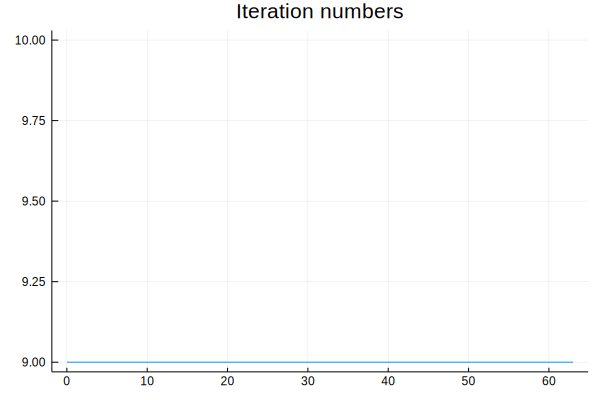

In [13]:
plot(sol1.t[2:end],iter1[2:end], title="Iteration numbers", legend=false)

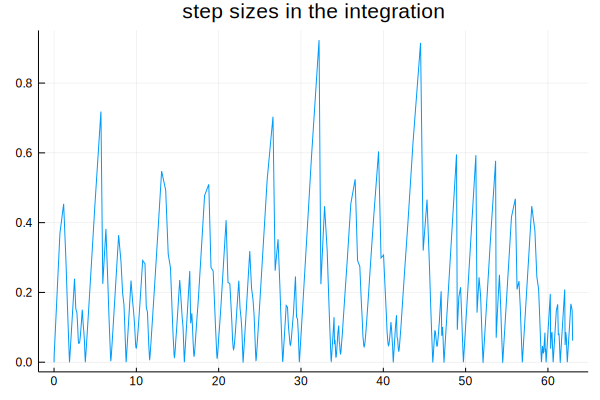

In [14]:
plot(sol1.t,steps1, title="step sizes in the integration", legend=false)

### Plots

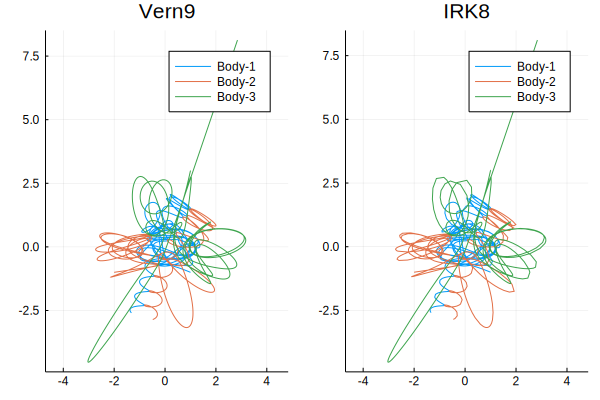

In [15]:
bodylist = ["Body-1", "Body-2", "Body-3"]
ulist0 = sol0.u
tlist0 = sol0.t

pl1 = plot(title="Vern9",aspect_ratio=1)

for j = 1:3
 xlist  = map(u->u[2,1,j], ulist0)
 ylist  = map(u->u[2,2,j], ulist0)
 pl1 = plot!(xlist,ylist, label = bodylist[j])   
end    


pl2 = plot(title="IRK8",aspect_ratio=1)

ulist1 = sol1.u[1:end]
tlist1 = sol1.t[1:end]

for j = 1:3
 xlist  = map(u->u[2,1,j], ulist1)
 ylist  = map(u->u[2,2,j], ulist1)
 pl2 = plot!(xlist,ylist, label = bodylist[j])   
end  


#plot(pl)
plot(pl1,pl2,layout=2) 

In [16]:
plot(pl2)
savefig("Burrau.png")

<a href="#top">Back to the top</a>

## Error in energy

In [17]:
setprecision(BigFloat, 256)
u0128, Gm =InitialBurrau(BigFloat)
(typeof(u0128),typeof(Gm))

(Array{BigFloat,3}, Array{Int64,1})

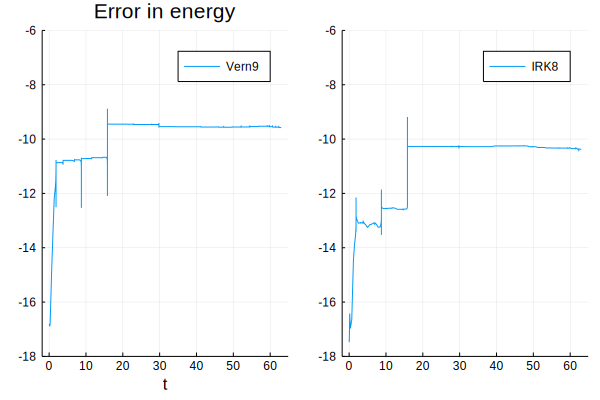

In [18]:
E0=NbodyEnergy(u0128,Gm)
end1=length(steps1)

ulist = sol0.u
tlist = sol0.t
EnergyErrors=[NbodyEnergy(BigFloat.(sol0.u[j]),Gm)/E0-1 for j in 1:length(tlist)]

ulist1 = sol1.u[1:end]
tlist1 = sol1.t[1:end]
EnergyErrors1=[NbodyEnergy(BigFloat.(sol1.u[j]),Gm)/E0-1 for j in 1:length(tlist1)]

ylimit1=-18
ylimit2=-6

p1=plot(tlist[1:end],log10.(abs.(EnergyErrors)),
    ylims=(ylimit1,ylimit2),
   xlabel="t", title="Error in energy", label="Vern9")
p2=plot(tlist1[1:end],log10.(abs.(EnergyErrors1)),
        ylims=(ylimit1,ylimit2),
    label="IRK8")
plot(p1,p2,layout=2)

In [19]:
(maximum(EnergyErrors),maximum(EnergyErrors1))

(1.310023474527760158794194188711431246473115332743836305211459228601649829505216e-09, 6.510450832995364775290226521451798574207835072048212219035471987805865050431809e-10)